In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import Optional,Iterable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from sklearn import metrics

In [2]:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def pkernel_loss(y_pred: torch.Tensor, loss: torch.nn.Module) -> torch.Tensor:
    total_loss = 0.
    B = y_pred.shape[0]
    n_classes = y_pred.shape[-1]
    for i in range(n_classes):
        y_target = torch.zeros_like(y_pred).scatter(1, torch.tensor([i], dtype=torch.long, device=y_pred.device).repeat(B).unsqueeze(1), 1)
        total_loss += loss(y_pred.float(), y_target)
    total_loss = total_loss / n_classes**0.5
    return total_loss

def get_gradient(model: torch.nn.Module, x: torch.Tensor, loss_fn: callable, opt: torch.optim.Optimizer, flatten: bool = False, use_label: bool = False, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    """
    Get the gradient of each element of the batch in x of the model with respect to the loss function
    
    Args:
        model: the model to use
        x: the input data [N_samples, ...]
        y: the target data [N_samples, ...]
        loss_fn: the loss function to use
        opt: the optimizer to use
        positive: whether to perturb the loss function positively or negatively
        kernel: What type of kernel to use, can either be pKernel, direct or average
        
    Returns:
        grads: the gradients of the model with respect to the loss function
    """
    B = len(x)
    device = next(model.parameters()).device
    x = x.to(device)
    if y is not None:
        y = y.to(device).float()
    opt.zero_grad()
    y_pred = model(x)
    if use_label:
        y_target = y
    else:
        y_target = y_pred.detach().argmax(1)
        y_target = torch.zeros_like(y_pred).scatter(1, y_target.unsqueeze(1), 1)
       
    loss = pkernel_loss(y_pred, loss_fn)
    # Trick to get gradient with respect to each sample in parallel
    grads = torch.autograd.grad(loss, model.parameters(), is_grads_batched=True, grad_outputs=torch.eye(B).to(device))
    if flatten:
        grads = torch.cat([grad.view((B, -1)) for grad in grads], -1)
    return grads

class own_linear_layer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(own_linear_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.beta = 0.1
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        # Initialize the weights to normal distribution
        nn.init.normal_(self.weight, mean=0.0, std=1.0)
        if self.bias is not None:
            nn.init.normal_(self.bias, mean=0.0, std=1.0)
    
    def forward(self, x):
        return x @ self.weight.t()/(self.weight.shape[-1]**0.5) + self.beta*self.bias

class SingleLayerMLP(nn.Module):
    """ A simple single hidden-layer perceptron for MNIST classification """
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_layers: int = 1):
        super(SingleLayerMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Define layers
        self.layers = nn.ModuleList()
        self.layers.append(own_linear_layer(input_size, hidden_size))
        self.layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            self.layers.append(own_linear_layer(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(own_linear_layer(hidden_size, output_size))
        
        # Initialize weights
        for layer in self.layers:
            if isinstance(layer, own_linear_layer):
                layer.reset_parameters()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten input
        x = x.view(-1, self.input_size)
        
        # Forward pass
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_weights(self):
        return [layer.weight for layer in self.layers if isinstance(layer, own_linear_layer)]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers if isinstance(layer, own_linear_layer)]
    
    def set_weights(self, weights, biases, initial_gain):
        i = 0
        for layer in self.layers:
            if isinstance(layer, own_linear_layer):
                weight = weights[i]
                bias = biases[i]
                in_features = layer.in_features
                out_features = layer.out_features
                k_factor = initial_gain
                layer.weight.data = weight.data[:out_features, :in_features]*k_factor
                layer.bias.data = bias.data[:out_features]*k_factor
                i += 1
    

class GaussianFit(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, device: torch.device, kernel_method: str = "direct", noise_var: float = 0.0):
        super(GaussianFit, self).__init__()
        self.device = device
        self.model = model
        self.kernel_method = kernel_method
        self.noise_var = noise_var
        self.covariance_matrix = None
        self.optimizer = None
        
    def fit(self, data: Iterable[torch.Tensor], optimizer: torch.optim.Optimizer, loss_batched: torch.nn.Module):
        self.optimizer = optimizer
        self.loss = loss_batched
        xs, ys, y_hats = [], [], []
        with torch.no_grad():
            for x, y in data:
                xs.append(x)
                ys.append(y)
                y_hats.append(self.model(x.to(self.device)))
        xs = torch.cat(xs, 0).to(self.device)
        y = torch.cat(ys, 0).to(self.device)
        y_hat = torch.cat(y_hats, 0).to(self.device)
        self.label_diff = y - y_hat
        self.grads = get_gradient(self.model, xs, loss_batched, self.optimizer, True, True, y=y)
        self.update_w()
        
    def update_noise(self, noise_var: float):
        self.noise_var = noise_var
        self.update_w()
        
    def update_w(self):
        self.covarinace_kernel = self.grads@self.grads.T
        self.covariance_matrix = self.covarinace_kernel.clone()
        self.covariance_matrix[range(self.covariance_matrix.shape[0]), range(self.covariance_matrix.shape[0])] += self.noise_var
        self.W = torch.linalg.solve(self.covariance_matrix.cpu(), self.label_diff.cpu()).to(self.device)
        
    def encode_x(self, x: torch.Tensor) -> torch.Tensor:
        """ Function transforming input x into the gradient kernel space """
        x_grad = get_gradient(self.model, x, self.loss, self.optimizer, True, True)
        return x_grad @ self.grads.T
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_grad = get_gradient(self.model, x, self.loss, self.optimizer, True, True)
        K_xX = x_grad@self.grads.T
        with torch.no_grad():
            y_hat = self.model(x)
        return y_hat + K_xX @ self.W
 
def MSELoss_batch(y_hat, y):
    return 0.5*(y_hat-y).pow(2).sum(-1)


def decision_boundary(x: torch.Tensor, threshold: float, flip_chance: float = 0) -> torch.Tensor:
    y = ((x[:, 0] > threshold) | (x[:, 1] > threshold)).float()
    should_flip = torch.rand(y.size()) < flip_chance
    y[should_flip] = 1 - y[should_flip]
    return y


def sample_data(n: int, threshold: float = 0.5**0.5, seed: Optional[int] = None, flip_chance: float = 0) -> tuple[torch.Tensor, torch.Tensor]:
    if seed is not None:
        torch.manual_seed(seed)
    x = torch.rand(n, 2)
    y = decision_boundary(x, threshold, flip_chance)
    return x, y

def plot_decision_boundary(model: torch.nn.Module, data, fig, ax, title = None) -> None:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    x_grid = data["x_grid"]
    N_testing = data["N_testing"]
    threshold = data["threshold"]
    
    model.eval()
    y_hat = torch.stack([model.forward(x_test_batch) for x_test_batch in torch.split(x_test, 100)]).view(-1)
    y_acc = (y_hat >= 0.5)== ((x_test[:, 0] > threshold) | (x_test[:, 1] > threshold))
    ax.clear()
    
    y_hat_reshape = y_hat.view(int(N_testing**0.5), int(N_testing**0.5)).detach().numpy().reshape(int(N_testing**0.5), int(N_testing**0.5))
    # Plot decision boundary
    # Color blue if y_hat > 0.5, red if y_hat < 0.5 by making a colormap of two colors
    colors = ["tab:red", "tab:blue"]
    custom_cmap = plt.cm.colors.ListedColormap(colors)
    ax.contourf(*x_grid, y_hat_reshape >0.5, alpha=0.5, levels=torch.linspace(-5.5, 5.5, 3), cmap=custom_cmap)
     
    # Plot training data
    ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], c='r', label='Class 0', s=4, marker='x')
    ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], c='b', label='Class 1', s=4, marker='x')
    # Add title
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Accuracy: {:.2f}'.format(y_acc.float().mean().item()))
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    
    # Add striped line to mark the decision boundary (x0 < threshold and x1 < threshold)
    ax.plot([0, threshold], [threshold, threshold], 'k--')
    ax.axvline(x=threshold, color='k', linestyle='--', ymax=threshold, label='Correct Decision boundary')
    ax.legend(loc='upper center')
    model.train()
    
def plot_NTK_decision_boundary(model, data, noise_var: float = 0.0, ax: Optional[plt.Axes] = None, fig: Optional[plt.Figure] = None, title = None):
    n_hidden = data.get("n_hidden", 64)
    assert isinstance(n_hidden, int)
    gradient_loader = data["gradient_loader"]
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    kernel_model = GaussianFit(model, "cpu", noise_var=noise_var)
    kernel_model.fit(gradient_loader, optimizer, MSELoss_batch)
    plot_decision_boundary(kernel_model, data, fig, ax, title)
    plt.show()



  0%|          | 0/10000 [00:00<?, ?it/s]

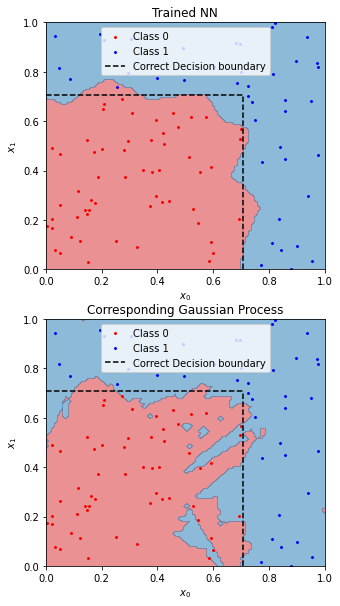

In [67]:
##### START OF DEMO #####
# Setup data
threshold   = 0.5**0.5
flip_chance = 0.0
N_training  = 100
N_testing   = 10**4
x_train, y_train = sample_data(N_training, seed=0, flip_chance=flip_chance, threshold=threshold)
gradient_loader = DataLoader([(x_train[i], y_train[i, None]) for i in range(N_training)], batch_size=64, shuffle=False)

# Construct grid of sqrt(N_testing) x sqrt(N_testing) points
x = torch.linspace(0, 1, int(N_testing**0.5))
x_grid = torch.meshgrid(x, x, indexing='ij')
x_test = torch.stack([x_grid[0].flatten(), x_grid[1].flatten()], 1)
y_test = decision_boundary(x_test, threshold)


# Construct NN_model
n_in = 2
n_out = 1
n_hidden = 16*128
model_arch = SingleLayerMLP
criterion = lambda x, y: ((x-y)**2).mean()  # We need L2 loss for NTK
train_model = model_arch(n_in, n_out, n_hidden)
optimizer = torch.optim.SGD(train_model.parameters(), lr=1., momentum=0.9)

# combine into one data
data = {
    "threshold"       : threshold, 
    "flip_chance"     : flip_chance,
    "N_training"      : N_training,
    "N_testing"       : N_testing,
    "x_train"         : x_train,
    "x_test"          : x_test,
    "y_train"         : y_train,
    "y_test"          : y_test,
    "x_grid"          : x_grid,
    "n_in"            : n_in,
    "n_out"           : n_out,
    "n_hidden"        : n_hidden,
    "gradient_loader" : gradient_loader,
}

# Train network to compare decision boundaries 
train_model.train()
for i in tqdm(range(10000)):
    for x, y in gradient_loader:
        optimizer.zero_grad()
        y_hat = train_model(x)
        # print(y_hat.shape,y.shape)
        loss = ((y_hat - y.float())**2).mean()
        loss.backward()
        optimizer.step()
        
    
# Plot decision boundary
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(5, 10)
plot_decision_boundary(train_model, data, fig, ax[0], 'Trained NN')

plot_NTK_decision_boundary(train_model, data, 0, ax[1], fig, 'Corresponding Gaussian Process')
fig.tight_layout()
fig.patch.set_alpha(0)  # Make background transparent

# Save figure
fig.savefig('decision_boundary_comparison.png')
plt.show()

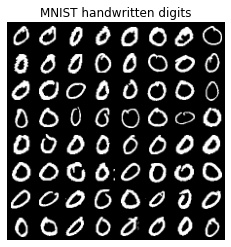

3000 1000
torch.Size([28, 28]) torch.Size([64, 1])


In [41]:
# data
train_set = MNIST("../../3_Feedforward_PyTorch/temp/", train=True, download=False, transform=transforms.ToTensor())
test_set = MNIST("../../3_Feedforward_PyTorch/temp/", train=False, download=False, transform=transforms.ToTensor())
batch_size = 64  # both for training and testing

# use only 3000 train and 1000 test
# train_loader = DataLoader([(train_set.data[i].float()/255, train_set.targets[i, None]) for i in range(len(train_set)//20)], batch_size=batch_size, shuffle=True,  num_workers=0, drop_last=False)
# test_loader  = DataLoader([(test_set.data[i].float()/255,  test_set.targets[i, None])  for i in range(1000)],               batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# #--- Limit for testing ---
train_ta = train_set.data[train_set.targets == 0][:1500].float()
train_tb = train_set.data[train_set.targets == 1][:1500].float()

train_la = train_set.targets[train_set.targets == 0][:1500]
train_lb = train_set.targets[train_set.targets == 1][:1500]
train_la[:] = 0
train_lb[:] = 1

x_train = torch.cat((train_ta,train_tb))
y_train = torch.cat((train_la,train_lb))

# test
test_ta = test_set.data[test_set.targets == 0][:500].float()
test_tb = test_set.data[test_set.targets == 1][:500].float()

test_la = test_set.targets[test_set.targets == 0][:500]
test_lb = test_set.targets[test_set.targets == 1][:500]
test_la[:] = 0
test_lb[:] = 1

x_test = torch.cat((test_ta,test_tb))
y_test = torch.cat((test_la,test_lb))

train_loader = DataLoader([(x_train[i].float()/255, y_train[i, None]) for i in range(3000)], batch_size=batch_size, shuffle=False,  num_workers=0, drop_last=False)
test_loader  = DataLoader([(x_test[i].float()/255,  y_test[i, None])  for i in range(1000)],               batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
# #--- Limit for testing ---

# plot a few MNIST examples
idx, dim, classes = 0, 28, 2
images, labels = next(iter(train_loader))
img = images.detach().cpu()

# create empty canvas
canvas = np.zeros((dim*8, 8*dim))

# fill with tensors
for i in range(8):
    for j in range(8):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = img[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()
print(len(train_loader.dataset),len(test_loader.dataset))
print(images[0].size(),labels.size())

In [42]:
N_training = len(train_loader.dataset)
N_testing  = len(test_loader.dataset)

# Construct NN_model
n_in = dim**2
n_out = classes
n_hidden = 64*128 # 64*128
model_arch = SingleLayerMLP
criterion = lambda x, y: ((x-y)**2).mean()  # We need L2 loss for NTK
train_model = model_arch(n_in, n_out, n_hidden)
optimizer = torch.optim.SGD(train_model.parameters(), lr=1., momentum=0.9)

if torch.cuda.is_available(): device = torch.device('cuda')  
else:                         device = torch.device('cpu')
print("Device:",device)
train_model.to(device)
print(train_model)

data = {
    "N_training"      : N_training,
    "N_testing"       : N_testing,
    "n_in"            : n_in,
    "n_out"           : n_out,
    "n_hidden"        : n_hidden,
    "gradient_loader" : train_loader,
}

Device: cuda
SingleLayerMLP(
  (layers): ModuleList(
    (0): own_linear_layer()
    (1): ReLU()
    (2): own_linear_layer()
  )
)


In [57]:
validation_every_steps = 100

# Train network to compare decision boundaries 
train_model.train()
train_acc_batches = []

for i in (pbar := tqdm(range(N_training))):
    total_loss = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = train_model(inputs)
        loss = ((output - targets.float())**2).sum()
        total_loss.append(round(float(loss),4))
        # print(loss)
        loss.backward()
        optimizer.step()
        
        if (i+1) % validation_every_steps == 0:
            predictions = output.max(1)[1]
            train_acc_batches.append(accuracy(targets, predictions))
    if (i+1) % 10 == 0:
        pbar.set_description(f"{sum(total_loss)}{total_loss}")
        
    if (i+1) % validation_every_steps == 0:
        
        train_acc = np.mean(train_acc_batches)
        train_accuracies_batches = []
        
        # Compute accuracies on validation set.
        valid_acc_batches = []
        with torch.no_grad():
            train_model.eval()
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output = train_model(inputs)
                loss = ((output - targets.float())**2).mean()

                predictions = output.max(1)[1]

                # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                valid_acc_batches.append(accuracy(targets, predictions))

            train_model.train()
        
        # Append average validation accuracy to list.
        valid_acc = np.mean(valid_acc_batches)
        
        pbar.set_description(f"Iter: {i+1:<4}  |  train_acc: {train_acc*100:.1f}%  |  test_acc: {valid_acc*100:.1f}%   ")

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
confusion_matrix = np.zeros((classes, classes))
with torch.no_grad():
    train_model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = train_model(inputs)
        loss = ((output - targets.float())**2).mean()

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.mean(test_accuracies)
    
    train_model.train()
print(f"Test accuracy: {test_accuracy*100:.1f}%")

Test accuracy: 9.4%


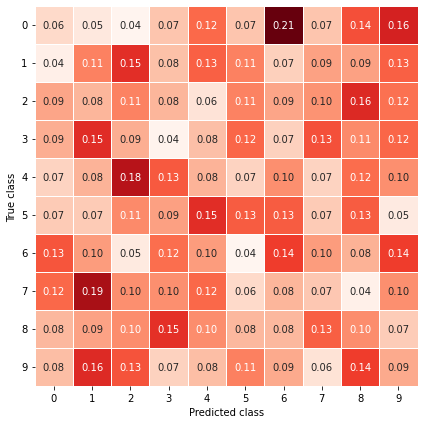

In [10]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = list(range(classes))
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()